# Homework 4. Molecular dynamics simulation  of 2D soft-disk fluid

In this homework, you will use molecular dynamics to simulate the behavior of fluid consisting of soft disks in two dimensions. The particles in this fluid interact with each other via the pairwise potential of the following form: 

 $$  u(r_{ij})=\left\{
                \begin{array}{ll}
                  4\epsilon \left[ 
                  \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{12} 
                  -
                   \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{6} + 
                  \right ] + \epsilon,  \ r_{ij} < r_c\\
                  0, r_{ij} \geq r_c, r_c = 2^{1/6}\sigma
                \end{array}
              \right.
$$

For this model, we will use reduced MD units, such that $\sigma = 1 $, $  \epsilon=1$,  $k_b = 1$.
All the particles have unit mass.

$ r_c = 2^{1/6}\sigma $

**The homework consists of 5 tasks, 25 points total. You should work in groups of 3-4 people and submit one solution for each group within 3 weeks. You can use GitHub for collaboration.**

## Task 1.  System initialization

1) Write a function that assigns coordinates of  N particles on a square grid inside a square box with side length L. This function should return a 2d array with coordinates for each particle. (1 pt)

2) Write a function that takes temperature as input and initializes particle velocities consistent with the given temperature. Make sure that the total momentum of the system is zero. (2 pt)


In [58]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [59]:
# reduced MD units
epsilon, m, kb, sigma = 1, 1, 1, 1

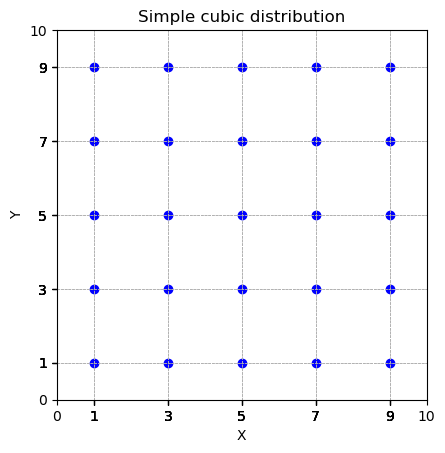

In [60]:
# This is a function which initialises the system
# INPUTS: Temperature (T), Length of the box (L), Number of particles (N)
# OUTPUTS: 
# x_matrix (N,2) for the positions, where the first column contanins the x-coordinates and the second the y-coordinates
# v_matrix (N,2) for the velocities, where the first column contanins the vx-coordinates and the second the vy-coordinates

# We define the inputs:
N=25 # The square root of N (total number of particles) should be an integer
L=10 # Length of the box
T=1 # Temperature (K)

def initialise_system(T, N, L):
    # assert that N is a square number
    assert N == math.isqrt(N) ** 2, "N should be a square number"
    # initialise positions
    d=L/N**0.5
    x = np.arange(d/2, L, d)  
    X, Y = np.meshgrid(x, x)
    r0_matrix = np.column_stack((X.flatten(),Y.flatten()))
    # initialise velocities
    v = np.sqrt(kb*T/m) * np.random.randn(N,2)
    p = np.sum(v*m, axis=0)
    v0_matrix=v-(p/(m*N))
    return r0_matrix, v0_matrix

r0_matrix, v0_matrix = initialise_system(T, N, L)
# print(x_matrix)
# print(v_matrix)
# print(x_matrix.shape)
# print(v_matrix.shape)

# Plot the points
plt.scatter(r0_matrix[:,0], r0_matrix[:,1], marker='o', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simple cubic distribution')

box_limits=np.array([0, L])
xlimits = np.around(np.append(r0_matrix[:,0], box_limits), decimals=1)
ylimits = np.around(np.append(r0_matrix[:,1], box_limits), decimals=1)

plt.xticks(xlimits)
plt.yticks(ylimits)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(0,L)
plt.ylim(0,L)

plt.show()

## Task 2. Building MD code  


1) Write code to perform molecular dynamics simulation of your system according to the following algorithm:

 *  Initialize positions, velocities, and accelerations for your system.
 * For each modeling step:
      - Update coordinates using velocity Verlet algorithm. (1 pt)
      - Apply periodic boundary conditions to coordinates. (1pt)
      - Calculate the force acting on each particle and accelerations. Keep in mind minimum image convention! (4 pt)
      - Update velocities using velocity Verlet algorithm. (1pt)

In [61]:
def velocity_verlet_integration(N, dt, nsteps, force, **kwargs):
    """
    Velocity Verlet integration
    """
    #1.update velocity halfway
    #2.update position using the intermediate velocity 
    #3.update velocity based on the updated position
    coordinates_verlet = np.zeros((nsteps,N,2))
    velocities_verlet = np.zeros((nsteps,N,2))

    # Initialisation 
    coordinates_verlet[0], velocities_verlet[0] = initialise_system(T,N,L)

    # calculate initial force once here, then rest will be recycled in each loop below  
    f1 = force(coordinates_verlet[0], epsilon, sigma)

    for i in range(nsteps-1):
        v_halfway = velocities_verlet[i] + 0.5*dt*f1 #1. velocity update    
        r_current = coordinates_verlet[i] + v_halfway*dt #2. update position using intermediate velocity
        # apply pbcs
        coordinates_verlet[i+1] = apply_pbc(L, r_current)
        # add minimum image to force
        f2 = force(coordinates_verlet[i+1], epsilon, sigma)
        velocities_verlet[i+1] = v_halfway + 0.5*dt*f2 #3.update velocity based on the updated position       
        f1 = f2     # store force for next loop 
       
    return coordinates_verlet, velocities_verlet

In [62]:
def f_lj(r, epsilon, sigma):
    F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))    
    return F

def f_lj_shifted_with_cutoff(r, sigma, epsilon):
    """
    LJ force resulting from potential shifted up by epsilon
    and truncated at r=sigma* 2^(1/6)
    """
    distances, vectors = calculate_distances_vectors(r, N, L)
    distances = np.expand_dims(distances, axis=-1)
    norm_vectors = vectors / distances
    norm_vectors = np.nan_to_num(norm_vectors, copy=True, nan=0.0)
    r_c = sigma*np.power(2, 1/6)
    force_magnitudes = np.zeros(distances.shape)
    forces = np.zeros(r.shape)
    r_below_c = np.argwhere(distances < r_c)
    force_magnitudes[r_below_c] = f_lj(distances[r_below_c], sigma, epsilon)
    force_magnitudes = np.nan_to_num(force_magnitudes, copy=True, nan=0.0)
    forces = force_magnitudes * norm_vectors
    forces = forces.sum(axis=1)
    return forces

In [63]:
def apply_pbc(L, r):
    """ L is length of box
        r is an (N,2) matrix
    """
    # I assumed here our box is from [0, L) instead of [-L/2, L/2) as we had before as I think that's how we initialised it 
    return r%L

    # if we want to do [-L/2, L/2) I think we can use this
    #def apply_pbc(L, r):
        #return (r + L/2)%L - L/2

In [64]:
def calculate_distances_vectors(r, N, L):
    distances = np.zeros((N,N))
    vectors = np.zeros((N,N,2))
    for i in range(N):
        for j in range(i+1, N):
            r_ij = r[j, :] - r[i, :]
            r_ij = r_ij - L * np.rint(r_ij / L)
            vectors[i, j] = r_ij
            vectors[j, i] = r_ij
            min_dist = np.linalg.norm(r_ij)
            distances[i, j] = min_dist
            distances[j, i] = min_dist
    return distances, vectors

In [66]:
dt=0.1
nsteps=1000
coordinates_verlet, velocities_verlet = velocity_verlet_integration(N, dt, nsteps, f_lj_shifted_with_cutoff)
# Force function call here - no f_lj

C:\Users\ev-s3\AppData\Local\Temp\ipykernel_12840\661040779.py:12: RuntimeWarning: invalid value encountered in divide
  norm_vectors = vectors / distances
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_12840\661040779.py:2: RuntimeWarning: divide by zero encountered in divide
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_12840\661040779.py:2: RuntimeWarning: invalid value encountered in add
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))


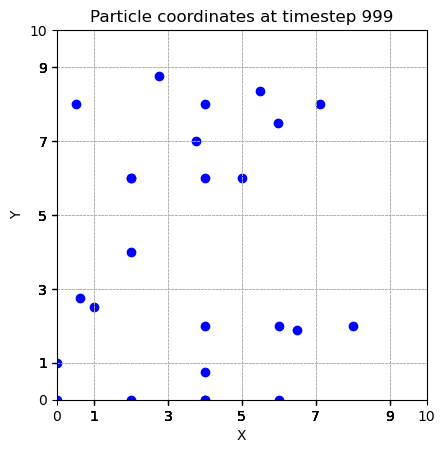

In [70]:
# Plot the points
timestep = 999
plt.scatter(coordinates_verlet[timestep,:,0], coordinates_verlet[timestep,:,1], marker='o', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Particle coordinates at timestep {timestep}')

box_limits=np.array([0, L])
xlimits = np.around(np.append(r0_matrix[:,0], box_limits), decimals=1)
ylimits = np.around(np.append(r0_matrix[:,1], box_limits), decimals=1)

plt.xticks(xlimits)
plt.yticks(ylimits)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(0,L)
plt.ylim(0,L)

plt.show()

In [69]:
coordinates_verlet[999]

array([[4.        , 0.        ],
       [4.        , 0.75      ],
       [6.        , 0.        ],
       [3.75      , 7.        ],
       [0.625     , 2.75      ],
       [2.        , 6.        ],
       [4.        , 8.        ],
       [0.        , 0.        ],
       [6.5       , 1.875     ],
       [4.        , 0.        ],
       [7.125     , 8.        ],
       [2.        , 0.        ],
       [5.        , 6.        ],
       [4.        , 6.        ],
       [2.75      , 8.75      ],
       [2.        , 6.        ],
       [1.        , 2.5       ],
       [5.97851562, 7.5       ],
       [2.        , 4.        ],
       [4.        , 2.        ],
       [8.        , 2.        ],
       [5.5       , 8.34375   ],
       [0.5       , 8.        ],
       [0.        , 1.        ],
       [6.        , 2.        ]])

In [ ]:
# AnimatedScatter class for the animation
class AnimatedScatter:
    def __init__(self):
        self.numpoints = N  # Update this according to your system
        self.stream = self.data_stream()

        # Setup the figure and axes
        self.fig, self.ax = plt.subplots()
        self.ani = FuncAnimation(self.fig, self.update, interval=10, init_func=self.setup_plot, blit=True, save_count=10)

    def setup_plot(self):
        # Initial drawing of the scatter plot
        x, y = self.stream[0][:, 0], self.stream[0][:, 1]
        self.scat = self.ax.scatter(x, y)
        self.ax.set_xlim(0, L)
        self.ax.set_ylim(0, L)
        return self.scat,

    def data_stream(self):
        #Generate data for animation
        coordinates_verlet, _ = velocity_verlet_integration(N, dt, nsteps, f_lj_shifted_with_cutoff)
        return coordinates_verlet

    def update(self, i):
        # Update the scatter plot
        data = self.stream[i]
        self.scat.set_offsets(data)
        return self.scat,

if __name__ == '__main__':
    a = AnimatedScatter()
    plt.show()

animation = AnimatedScatter(L, coordinates_verlet, nx=3, ny=1)
animation.run(frames=print(len(coordinates_verlet)), interval=1, blit=True)

In [ ]:
from matplotlib.animation import FuncAnimation

class TrajectoryAnimation():
    """
    Class handles animation of the trajectory.
    """
    
    def __init__(self, L, trajectory, nx=1, ny=1, sigma=1):
        """
        Create animation of the trajectory with
        size of the cell L and number of images in x and y
        direction nx and ny, correspondingly.
        
        Parameters:
        
        L:  float
              edge length of a square box
        trajectory: iterable
                    Iterable where each element is (Nx2) numpy.ndarray, 
                    where n represents number of particles in the system
                    
        nx, ny : int
        Number of periodic images in x and y directions, correspondingly
        -----------
        
        """
        self.L = L
        self.nx = nx
        self.ny = ny
        self.sigma = sigma
        
        self.fig = plt.figure()
        self.low_x = -L/2
        self.high_x = L/2*nx
        self.low_y = -L/2
        self.high_y  =L/2*ny
        self.ax = plt.axes(xlim=(self.low_x, self.high_x), ylim=(self.low_y, self.high_y))
        return 
    
    def init_animation(self):
        for particle in trajectory[0]:
            for x_image in range(self.nx):
                for  y_image in range(self.ny):
                    circle = plt.Circle(particle+self.nx*self.L, sigma/2, color='r')
        self.ax.set_xlim(self.low_x, self.high_x)
        self.ax.set_ylim(self.low_y, self.high_y)
        return self.ax
    
    def update_animation(self, i):
        self.ax.patches = []
        frame = trajectory[i]
        for particle in frame:
            for x_image in range(self.nx+1):
                for  y_image in range(self.ny+1):
                    coordinates = (particle[0] + x_image*self.L, particle[1] + y_image*self.L)
                    circle = plt.Circle(coordinates, self.sigma/2, color='blue')
                    self.ax.add_patch(circle)
        self.ax.set_xlim(self.low_x, self.high_x)
        self.ax.set_ylim(self.low_y, self.high_y)
        return self.ax
    
    def run(self, **kwargs):
        """
        Run animation. **kwars are passed to FuncAnimation
        """
        self.anim = FuncAnimation(self.fig, self.update_animation, init_func=self.init_animation, **kwargs)
                              
        return self.anim

In [ ]:
# Sample coordinates
animation = TrajectoryAnimation(L, coordinates_verlet, nx=3, ny=1)
animation.run(frames=range((len(coordinates_verlet))), interval=1, blit=True)

## Task 3. Simulations in the microcanonical ensemble

1) Use the code you wrote in task 3 to run MD simulation of a system with 49 particles in a square box with side length L = 7 for at least 5000 steps. Initialize velocities using T=1. Use integration step dt = 0.005. Save coordinates and velocities at each step to a file. (2 pt)

2) For each timestep, calculate and plot the following values as a function of time: $\sum_i^{N particles} V_x^i $, $\sum_y^{N particles} V_y^i $, $E_{total}$, $E_{potential}$, $E_{kinetic}$, temperature. Which of the these values should be conserved? Do your results match the prediction?  (3 pt)

3) Was the modeling time enough for the system to equilibrate? Explain.  (1 pt)


In [ ]:
# 1)
# Constants
N = 49  # Number of particles
L = 7   # Box side length
T = 1   # Temperature (K)
dt = 0.005  # Integration step

# Perform MD simulation
nsteps = 5000  # Number of steps
coordinates_verlet, velocities_verlet = velocity_verlet_integration(N, dt, nsteps, LJ_force)

# Save coordinates and velocities to a file
np.savez('md_simulation_output.npz', coordinates=coordinates_verlet, velocities=velocities_verlet)

In [ ]:
# Load the .npz file
data = np.load('md_simulation_output.npz')

# Display keys in the NPZ file
print("Keys in the file:", data.files)

# Access individual arrays within the .npz file
coordinates_verlet = data['coordinates']  
velocities_verlet = data['velocities']  

print(coordinates_verlet, velocities_verlet)


## Task 4. Constant temperature molecular  dynamics

In this task, you will extend code from task 2 to run the simulation at a constant temperature using Langevin dynamics.

1) Implement integration of the Langevin equation. (2 pt)

2) Simulate cooling of the liquid with 121 particles in the box with L=11. First, run the simulation at T=1.4 for 2000 steps. Use final coordinates and velocities to start another simulation, this time with T=1.2.  Run this lower-temperature simulation for 2000 steps. Keep restarting the simulation, each time decreasing the temperature by 0.2. The final run should be performed at T=0.6  In all the simulations, use a constant friction coefficient of your choice. (2 pt)

3) Visualize several frames from a low-temperature fragment of the trajectory. These frames represent the microscopic structure of the frozen soft-disk liquid. Is the structure different from the initial square-grid arrangement? (1 pt)

In [ ]:
# Constants for your system
m = 1  # Mass of particles (assuming it's 1 for simplicity)

# Initialize arrays to store the calculated values at each step
total_px = []
total_py = []
total_energy = []
potential_energy = []
kinetic_energy = []

# Define the Lennard-Jones potential function
def u_lj(r, sigma, epsilon):
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

# Function to calculate potential energy using LJ potential
def calculate_potential_energy(coordinates):
    r = np.linalg.norm(coordinates[:, np.newaxis] - coordinates, axis=2)
    np.fill_diagonal(r, 1)  # Avoid division by zero
    potential = u_lj_shifted_with_cutoff(r, sigma, epsilon)
    return np.sum(potential) / 2  # Divide by 2 to avoid double-counting

# Function to calculate kinetic energy
def calculate_kinetic_energy(velocities):
    return 0.5 * np.sum(np.linalg.norm(velocities, axis=1) ** 2)

# Function to calculate total energy
def calculate_total_energy(coordinates, velocities):
    return calculate_kinetic_energy(velocities) + calculate_potential_energy(coordinates)

# Loop through each step to calculate the required quantities
for step in range(len(coordinates_verlet)):
    positions = coordinates_verlet[step]
    velocities = velocities_verlet[step]

    # Calculate total momentum components
    total_px.append(np.sum(m * velocities[:, 0]))
    total_py.append(np.sum(m * velocities[:, 1]))
    
    # Calculate potential energy, kinetic energy, and total energy at each step
    potential_energy.append(calculate_potential_energy(positions))
    kinetic_energy.append(calculate_kinetic_energy(velocities))
    total_energy.append(calculate_total_energy(positions, velocities))

# Convert lists to numpy arrays
total_px = np.array(total_px)
total_py = np.array(total_py)
total_energy = np.array(total_energy)
potential_energy = np.array(potential_energy)
kinetic_energy = np.array(kinetic_energy)

# Plotting the quantities as a function of time
time_steps = np.arange(len(coordinates_verlet))

plt.figure(figsize=(10, 8))

plt.subplot(3, 2, 1)
plt.plot(time_steps, total_px, label='Total Px')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(time_steps, total_py, label='Total Py')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(time_steps, total_energy, label='Total Energy')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(time_steps, potential_energy, label='Potential Energy')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(time_steps, kinetic_energy, label='Kinetic Energy')
plt.legend()

plt.tight_layout()
plt.show()

## Task 5. Considerations when modeling realistic systems

It is easy to run a simulation that yields meaningless results when doing molecular dynamics simulation. To avoid this problem, one should know the properties and limitations of the algorithms used. To prevent some of the common pitfalls in the future, answer the following questions.

1) What is the maximum cut-off radius for nonbonded interactions in a periodic system with cubic box size L?  Explain your answer. (1 pt)

2) Can the Andersen thermostat be used to study dynamic properties of the system, such as diffusion coefficients. Why? (1 pt)

3) What is the purpose of the particle mesh Ewald (PME) algorithm? Please briefly describe the method and a) why it is used, b) which caveats does it have, c) what are the alternatives (3 pt)